In [4]:
import numpy as np
import tqdm

import torch
import os
import glob

Index(['Unnamed: 0', 'CL_src', 'CL_tgt', 'D_src', 'D_tgt', 'H_tgt', 'VAT_src',
       'VAT_tgt', 'acc_s', 'acc_t', 'batch', 'ce', 'epoch'],
      dtype='object')


/usr/local/lib/python3.5/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


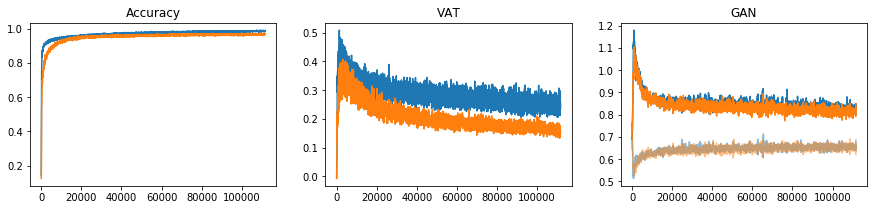

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
%matplotlib inline

smooth  = lambda x : scipy.signal.savgol_filter(x, window_length=125, polyorder=2)

#df = pd.read_csv('log/visda-multidomain/20180816-013520_MultidomainBCESolver/losshistory.csv')
df = pd.read_csv('log/dirtt/20180816-233249_VADASolver/losshistory.csv')

print(df.columns)

def plot_smoothed(x, **kwargs):
    plt.plot(smooth(x), **kwargs)

plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plot_smoothed(df['acc_s'], c='C0')
plot_smoothed(df['acc_t'], c='C1')
plt.title('Accuracy')

plt.subplot(1,3,2)
plot_smoothed(df['VAT_src'], c='C0')
plot_smoothed(df['VAT_tgt'], c='C1')
plt.title('VAT')

plt.subplot(1,3,3)
plot_smoothed(df['CL_src'], c='C0')
plot_smoothed(df['D_src'], c='C0', alpha=.5)
plot_smoothed(df['CL_tgt'], c='C1')
plot_smoothed(df['D_tgt'], c='C1', alpha=.5)
plt.title('GAN')
plt.show()

In [4]:
#! /gpfs01/bethge/home/sschneider/bin/visda.sh

In [5]:
checkpoints = list(glob.glob('log/dirtt/20180816-233249_VADASolver/20180816-233249-checkpoint-ep237.pth'))
checkpoints = sorted(sorted(checkpoints), key=len)
print(len(checkpoints))

1


In [6]:
from evaluate import evaluate

In [8]:
from torchvision import transforms, datasets
import os.path as osp
from torch.utils.data import DataLoader
import salad.datasets

from train_dirtt import SVHN_MNIST_Model, ConditionalBatchNorm

data = salad.datasets.da.load_dataset2(path="/tmp/data", train=False)

train_loader = DataLoader(data['mnist'], shuffle=True, batch_size=32, num_workers=16)
val_loader   = DataLoader(data['svhn'], shuffle=True, batch_size=64, num_workers=16)

In [9]:
from evaluate import evaluate

lt,pt,ft = evaluate(checkpoints, val_loader, domain=0)

100%|██████████| 407/407 [00:05<00:00, 70.42it/s]


In [10]:
print(pt.shape, lt.shape)

logit_tgt = pt.squeeze()
lbl_tgt   = lt.squeeze()

(1, 26032, 10) (1, 26032)


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1744
          1       0.98      0.98      0.98      5099
          2       0.99      0.98      0.98      4149
          3       0.97      0.95      0.96      2882
          4       0.98      0.98      0.98      2523
          5       0.97      0.98      0.97      2384
          6       0.97      0.98      0.97      1977
          7       0.98      0.97      0.98      2019
          8       0.97      0.97      0.97      1660
          9       0.94      0.98      0.96      1595

avg / total       0.98      0.98      0.98     26032



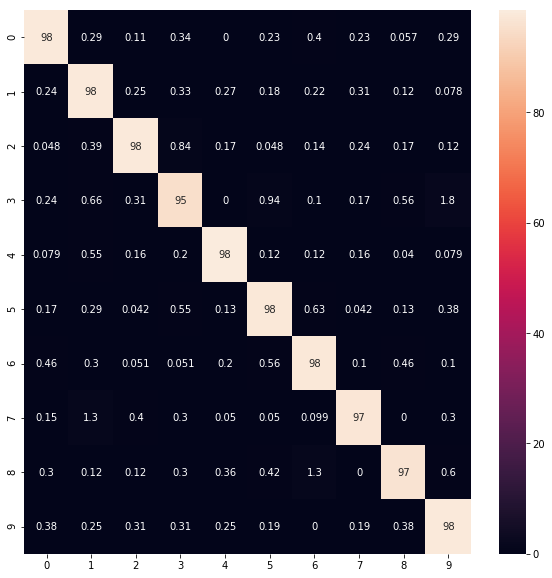

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cfm = confusion_matrix(lbl_tgt, logit_tgt.argmax(axis=-1))

print(classification_report(lbl_tgt, logit_tgt.argmax(axis=-1)))

cfm = cfm / cfm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,10))
sns.heatmap(100*cfm, annot=True)
plt.show()

#cfm = cfm / cfm.sum(axis=1)
#plt.figure(figsize=(10,10))
#sns.heatmap(100*cfm, annot=True)
#plt.show()

In [23]:
np.diag(cfm).mean()

0.806686001836199

In [54]:
import pandas as pd

df_src = pd.read_csv('/tmp/visda/train/image_list.txt', sep=' ', header=None, names=['fname', 'class'])
df_tgt = pd.read_csv('/tmp/visda/validation/image_list.txt', sep=' ', header=None, names=['fname', 'class'])

In [55]:
len(lt)

1

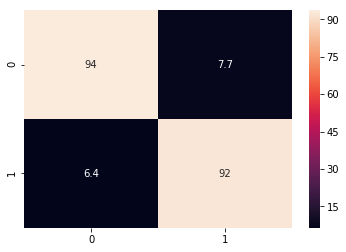

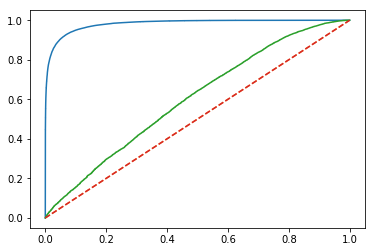

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

lbl_src = l.squeeze() == 7
logit_src = p.squeeze()

cfm = confusion_matrix(l.squeeze() == 7, p.squeeze() > 0)
cfm = cfm / cfm.sum(axis=0)

sns.heatmap(100*cfm, annot=True)
plt.show()

fpr, tpr, thresholds = roc_curve(lbl_src, logit_src)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')

fpr, tpr, thresholds = roc_curve(lbl_tgt, logit_tgt)

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, '--')

plt.show()

In [7]:
ds = datasets['target']

ds.classes

['aeroplane',
 'bicycle',
 'bus',
 'car',
 'horse',
 'knife',
 'motorcycle',
 'other',
 'person',
 'plant',
 'skateboard',
 'train',
 'truck']

In [56]:
p.shape, l.shape

((55281, 1), (55281,))

In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


p.shape, l.shape
print(confusion_matrix(l, p.squeeze()>.5))

print(classification_report(l, p.argmax(axis=-1), target_names=ds.classes))

[[ 3095  2439]
 [15101 34646]]
             precision    recall  f1-score   support

      known       0.10      1.00      0.18      5534
    unknown       0.00      0.00      0.00     49747

avg / total       0.01      0.10      0.02     55281



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
cfm = confusion_matrix(l, p.argmax(axis=-1))

print(accuracy_score(l, p.argmax(axis=-1)))

(np.diag(cfm) / cfm.sum(axis=0)) * 100

0.34622334658474885


array([41.91419142, 50.51194539, 44.76987448, 39.90990991, 79.42857143,
       11.72638436, 44.9122807 , 50.61728395, 31.21597096, 14.38848921,
       22.10526316, 12.90322581])

In [24]:
datasets = load_dataset('/data/visda_full/')

ResNetModel?

/data/visda_full/train


Init signature: ResNetModel(backbone, n_classes=12)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
           x = F.relu(self.conv1(x))
           return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call `.cuda()`, etc.
File:           ~/thesis/code/domainadaptation/train_visda.py
Type:           type
